In [ ]:
import os
from datetime import datetime, timedelta
import ee, geemap
PROJECT_ID = 'earth-engine-project-470617'
try:
    ee.Initialize(project=PROJECT_ID)
except Exception:
    ee.Authenticate(); ee.Initialize(project=PROJECT_ID)
print('EE initialized with project:', PROJECT_ID)

Pauri = ee.Geometry.Rectangle([78.5, 29.5, 79.8, 30.4])

START_DATE = '2016-04-09'
END_DATE   = '2016-06-15'

OUTPUT_DIR = 'daily_stacks'
os.makedirs(OUTPUT_DIR, exist_ok=True)

EXPORT_DAILY_STACKS = True
print(f'Config ready: {START_DATE} -> {END_DATE}  EXPORT_DAILY_STACKS={EXPORT_DAILY_STACKS}')

EE initialized with project: earth-engine-project-470617
Config ready: 2016-04-09 -> 2016-06-15  EXPORT_DAILY_STACKS=True


In [ ]:
EXPORT_SEPARATE_BANDS = True   
SEPARATE_DIR = 'daily_bands'

if EXPORT_DAILY_STACKS:
    import pathlib
    scale = 500
    crs = 'EPSG:4326'
    pathlib.Path(SEPARATE_DIR).mkdir(exist_ok=True)
    
    lulc = ee.ImageCollection('ESA/WorldCover/v100').first().select('Map').rename('LULC').clip(Pauri)
    dem = ee.Image('USGS/SRTMGL1_003').clip(Pauri).rename('DEM')
    terrain = ee.Terrain.products(dem)
    slope = terrain.select('slope').rename('Slope')
    aspect = terrain.select('aspect').rename('Aspect')
    hillshade = ee.Terrain.hillshade(dem).rename('Hillshade')
    
    era5 = ee.ImageCollection('ECMWF/ERA5/DAILY')
    ndvi_ic = ee.ImageCollection('MODIS/061/MOD13Q1').select('NDVI')
    burn_ic = ee.ImageCollection('MODIS/061/MCD64A1').select('BurnDate')
    start_dt = datetime.strptime(START_DATE, '%Y-%m-%d')
    end_dt   = datetime.strptime(END_DATE, '%Y-%m-%d')
    cur = start_dt
    print('Beginning daily export loop ...')
    while cur <= end_dt:
        dstr = cur.strftime('%Y-%m-%d')
        day = ee.Date(dstr)
        
        temp = era5.filterDate(day, day.advance(1,'day')).select('mean_2m_air_temperature').mean().add(-273.15).rename('TempC')
        u    = era5.filterDate(day, day.advance(1,'day')).select('u_component_of_wind_10m').mean().rename('U10')
        v    = era5.filterDate(day, day.advance(1,'day')).select('v_component_of_wind_10m').mean().rename('V10')
        wspd = u.pow(2).add(v.pow(2)).sqrt().rename('WindSpeed')
        ndvi = ndvi_ic.filterDate(day.advance(-16,'day'), day.advance(1,'day')).mean().multiply(0.0001).rename('NDVI')
        burn = burn_ic.filterDate(day.advance(-32,'day'), day.advance(1,'day')).mosaic().rename('BurnDate')
        
        daily_stack = temp.addBands([u, v, wspd, ndvi, burn, lulc, dem, slope, aspect, hillshade])
        out_stack_path = os.path.join(OUTPUT_DIR, f'pauri_stack_{dstr}.tif')
       
        if not os.path.exists(out_stack_path):
            print('Exporting stacked', out_stack_path)
            geemap.ee_export_image(daily_stack, filename=out_stack_path, region=Pauri, scale=scale, crs=crs, file_per_band=False)
        else:
            print('Stack exists, skip', out_stack_path)
       
        if EXPORT_SEPARATE_BANDS:
            band_dir = os.path.join(SEPARATE_DIR, dstr)
            pathlib.Path(band_dir).mkdir(parents=True, exist_ok=True)
            band_names = ['TempC','U10','V10','WindSpeed','NDVI','BurnDate','LULC','DEM','Slope','Aspect','Hillshade']
            for idx, bname in enumerate(band_names):
                band_file = os.path.join(band_dir, f'{bname}.tif')
                if os.path.exists(band_file):
                    continue
                
                single = daily_stack.select(idx)
                try:
                    geemap.ee_export_image(single, filename=band_file, region=Pauri, scale=scale, crs=crs, file_per_band=False)
                except Exception as e:
                    print('Band export failed', bname, e)
        cur += timedelta(days=1)
    print('Daily exports complete.')
else:
    print('Skipping export (EXPORT_DAILY_STACKS False).')

Beginning daily export loop ...
Stack exists, skip daily_stacks\pauri_stack_2016-04-09.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to c:\Users\91823\Downloads\Agnirodhak_D\daily_bands\2016-04-09\TempC.tif
Generating URL ...
Data downloaded to c:\Users\91823\Downloads\Agnirodhak_D\daily_bands\2016-04-09\TempC.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to c:\Users\91823\Downloads\Agnirodhak_D\daily_bands\2016-04-09\U10.tif
Generating URL ...
Data downloaded to c:\Users\91823\Downloads\Agnirodhak_D\daily_bands\2016-04-09\U10.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to c:\Users\91823\Downloads\Agnirodhak_D\daily_bands\2016-04-09\V10.tif
Generating URL ...
Data downloaded to c:\Users\91823\Downloads\Agnirodhak_D\daily_bands\2016-04-09\V10.tif
Generating URL ...
Please wait ...
Please wait ...
Data downloaded to c:\Users\91823\Downloads\Agnirodhak_D\daily_bands\2016-04-09\WindSpeed.tif
Generating URL ...
Dat

In [ ]:
import glob, rasterio, numpy as np, os
STACK_PATTERN = os.path.join(OUTPUT_DIR, 'pauri_stack_*.tif')
stack_files = sorted(glob.glob(STACK_PATTERN))
stack_list = []
dates = []
if stack_files:
    print(f'Found {len(stack_files)} stacked daily files.')
    for f in stack_files:
        dates.append(f.split('_')[-1].replace('.tif',''))
        with rasterio.open(f) as src:
            arr = src.read()  
        if arr.shape[0] != 11:
            raise RuntimeError('Unexpected band count in ' + f)
        stack_list.append(arr.astype('float32'))
else:
   
    BAND_DIR_ROOT = 'daily_bands'
    band_names = ['TempC','U10','V10','WindSpeed','NDVI','BurnDate','LULC','DEM','Slope','Aspect','Hillshade']
    date_dirs = sorted([d for d in os.listdir(BAND_DIR_ROOT) if os.path.isdir(os.path.join(BAND_DIR_ROOT,d))])
    if not date_dirs:
        raise SystemExit('No stacked files or per-band directories found. Run Cell 2.')
    print('Reconstructing stack from per-band directories...')
    for d in date_dirs:
        band_arrays = []
        valid = True
        first_shape = None
        for b in band_names:
            path = os.path.join(BAND_DIR_ROOT, d, f'{b}.tif')
            if not os.path.exists(path):
                print('Missing band', b, 'for date', d, 'skipping date.')
                valid = False; break
            with rasterio.open(path) as src:
                arr = src.read(1) 
            if first_shape is None:
                first_shape = arr.shape
            else:
                if arr.shape != first_shape:
                    print('Shape mismatch for', d, b, 'skipping date.')
                    valid = False; break
            band_arrays.append(arr.astype('float32'))
        if not valid:
            continue
        stack_list.append(np.stack(band_arrays, axis=0))
        dates.append(d)
    if not stack_list:
        raise SystemExit('No valid reconstructed days.')

stack = np.stack(stack_list, axis=0)  
T,B,H,W = stack.shape
print('Loaded data shape:', stack.shape, '| Days:', len(dates))

B_TEMP,B_U,B_V,B_WS,B_NDVI,B_BURN = 0,1,2,3,4,5
B_LULC,B_DEM,B_SLOPE,B_ASPECT,B_HILL = 6,7,8,9,10
means_day0 = stack[0].reshape(11,-1).mean(axis=1)
print('Day0 band means:', means_day0)


Found 68 stacked daily files.
Loaded data shape: (68, 11, 202, 290) | Days: 68
Day0 band means: [ 1.8828482e+01  1.3325223e-01 -7.0163906e-01  8.0144805e-01
  4.7680870e-01  5.0978832e+00  1.5748208e+01  1.5476156e+03
  1.3926869e+01  1.7728465e+02  1.7899951e+02]
Cell 3 completed (data loaded). Proceed to Cell 3b (optional write) then 3c for visualization.
Loaded data shape: (68, 11, 202, 290) | Days: 68
Day0 band means: [ 1.8828482e+01  1.3325223e-01 -7.0163906e-01  8.0144805e-01
  4.7680870e-01  5.0978832e+00  1.5748208e+01  1.5476156e+03
  1.3926869e+01  1.7728465e+02  1.7899951e+02]
Cell 3 completed (data loaded). Proceed to Cell 3b (optional write) then 3c for visualization.


In [35]:
WRITE_RECONSTRUCTED_STACKS = True  
STACK_DTYPE = 'float32'
if WRITE_RECONSTRUCTED_STACKS and not stack_files:
    import rasterio
    from rasterio.transform import from_bounds
   
    sample_day_dir = os.path.join('daily_bands', dates[0])
    sample_band_path = os.path.join(sample_day_dir, 'TempC.tif')
    with rasterio.open(sample_band_path) as ssrc:
        profile = ssrc.profile.copy()
        transform = ssrc.transform
        crs = ssrc.crs
    profile.update(count=11, dtype=STACK_DTYPE)
    print('Writing stacked daily GeoTIFFs to', OUTPUT_DIR)
    band_names_order = ['TempC','U10','V10','WindSpeed','NDVI','BurnDate','LULC','DEM','Slope','Aspect','Hillshade']
    for arr, dstr in zip(stack_list, dates):
        out_path = os.path.join(OUTPUT_DIR, f'pauri_stack_{dstr}.tif')
        if os.path.exists(out_path):
            continue
        with rasterio.open(out_path, 'w', **profile) as dst:
            for i in range(11):
                dst.write(arr[i].astype(STACK_DTYPE), i+1)
            dst.update_tags(**{f'B{i+1}': band_names_order[i] for i in range(11)})
        print('Wrote', out_path)
    print('Local stacking complete.')
elif WRITE_RECONSTRUCTED_STACKS and stack_files:
    print('Stacked files already exist; skipping local write.')
else:
    print('Skipped writing reconstructed stacks.')


Stacked files already exist; skipping local write.


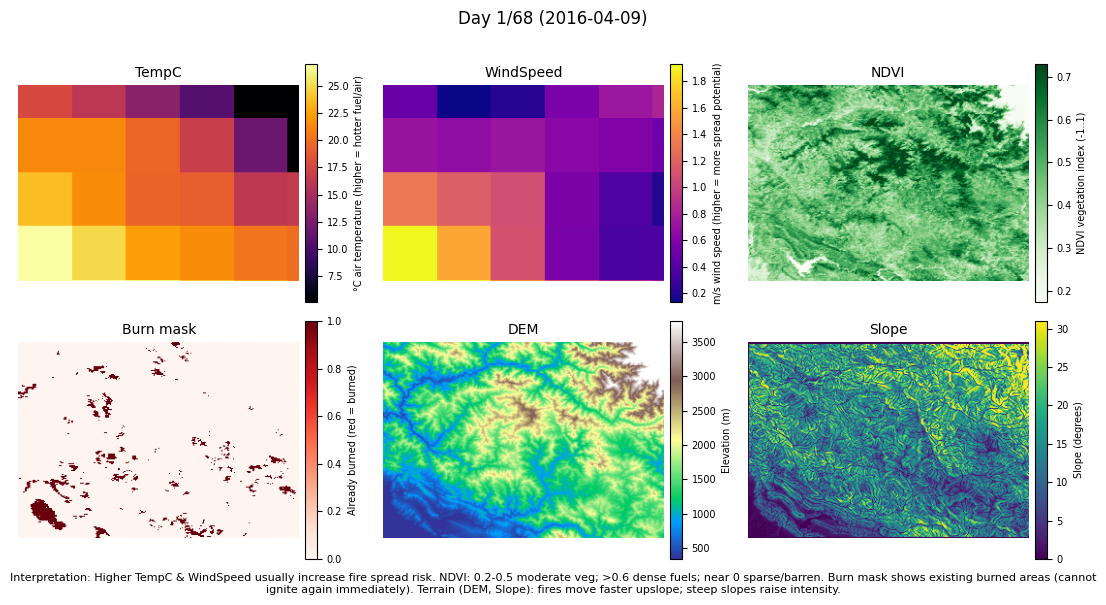

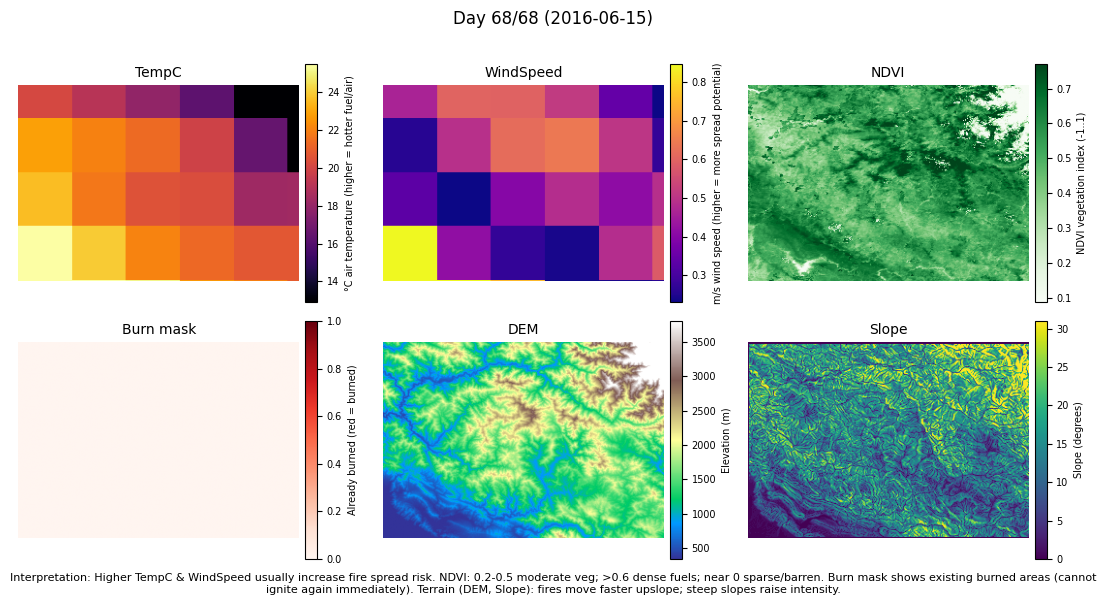

Cell 3c visualization complete. Continue to Cell 4 for dataset construction.


In [ ]:
SHOW_LAST = True     
SAVE_FIGS = False     
FIG_DIR = 'figures'
KEY_BANDS = [
    ('TempC', B_TEMP, '°C air temperature (higher = hotter fuel/air)', 'inferno'),
    ('WindSpeed', B_WS, 'm/s wind speed (higher = more spread potential)', 'plasma'),
    ('NDVI', B_NDVI, 'NDVI vegetation index (-1..1)', 'Greens'),
    ('Burn mask', B_BURN, 'Already burned (red = burned)', 'Reds'),
    ('DEM', B_DEM, 'Elevation (m)', 'terrain'),
    ('Slope', B_SLOPE, 'Slope (degrees)', 'viridis')
]
import numpy as np, os
import matplotlib.pyplot as plt
if SAVE_FIGS:
    os.makedirs(FIG_DIR, exist_ok=True)
sel_days = [0] + ([T-1] if SHOW_LAST and T>1 else [])
for di in sel_days:
    fig, axes = plt.subplots(2,3, figsize=(11,6))
    fig.suptitle(f'Day {di+1}/{T} ({dates[di] if di < len(dates) else di})')
    for ax, (name, idx, desc, cmap) in zip(axes.ravel(), KEY_BANDS):
        data = stack[di, idx]
        if name == 'Burn mask':
            data_plot = (data>0).astype(float)
            vmin, vmax = 0,1
        else:
            data_plot = data
            vmin, vmax = np.nanpercentile(data_plot,2), np.nanpercentile(data_plot,98)
            if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin==vmax:
                vmin, vmax = np.nanmin(data_plot), np.nanmax(data_plot)
        im = ax.imshow(data_plot, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_title(f'{name}', fontsize=10)
        ax.axis('off')
        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
        cbar.ax.tick_params(labelsize=7)
        cbar.set_label(desc, fontsize=7)
    expl = (
        'Interpretation: Higher TempC & WindSpeed usually increase fire spread risk. NDVI: 0.2-0.5 moderate veg; >0.6 dense fuels; near 0 sparse/barren. '
        'Burn mask shows existing burned areas (cannot ignite again immediately). Terrain (DEM, Slope): fires move faster upslope; steep slopes raise intensity.'
    )
    fig.text(0.5, 0.005, expl, ha='center', va='bottom', fontsize=8, wrap=True)
    plt.tight_layout(rect=(0,0.03,1,0.97))
    if SAVE_FIGS:
        out = os.path.join(FIG_DIR, f'key_bands_day{di+1}.png')
        plt.savefig(out, dpi=150)
        print('Saved figure', out)
    plt.show()


In [ ]:
import numpy as np
from scipy.ndimage import binary_dilation

LAG_DAYS = 3                
INCLUDE_DIFFS = True        
DILATE_LABELS = True       
DILATION_RADIUS = 1          
MIN_TRAIN_POS_IGNITION = 50  

DYN_BASE_IDXS = [B_TEMP, B_U, B_V, B_WS, B_NDVI]
STATIC_IDXS = [B_LULC, B_DEM, B_SLOPE, B_ASPECT, B_HILL]

transitions = T - 1  
if LAG_DAYS < 1:
    raise ValueError('LAG_DAYS must be >=1')

structure = np.ones((3,3), dtype=bool) if DILATE_LABELS else None
feature_rows = []
anyburn_rows = []
ignite_rows = []

for t in range(LAG_DAYS-1, T-1):  
    
    dyn_lags = []
    for lag in range(LAG_DAYS):
        tt = t - lag
        dyn_slice = stack[tt, DYN_BASE_IDXS]  
        dyn_lags.append(dyn_slice)
  
    dyn_lags = dyn_lags[::-1]  
    dyn_lags_arr = np.stack(dyn_lags, axis=0)  
    
    burn_now = (stack[t, B_BURN] > 0).astype('float32')
   
    static_feats = stack[t, STATIC_IDXS]  

    diff_feats = []
    if INCLUDE_DIFFS and LAG_DAYS > 1:
        for k in range(1, LAG_DAYS):
            diff = dyn_lags_arr[k] - dyn_lags_arr[k-1]  
            diff_feats.append(diff)
    if diff_feats:
        diff_feats_arr = np.stack(diff_feats, axis=0)  
       
        diff_feats_arr = diff_feats_arr.reshape(-1, H, W)
   
    dyn_lags_flat = dyn_lags_arr.reshape(LAG_DAYS*5, H, W)
    parts = [dyn_lags_flat]
    if diff_feats:
        parts.append(diff_feats_arr)
    parts.append(burn_now[None, ...])
    parts.append(static_feats)
    feats_full = np.concatenate(parts, axis=0) 
    F = feats_full.shape[0]
   
    burn_next = (stack[t+1, B_BURN] > 0).astype('uint8')
    any_burn = burn_next.copy()
    if DILATE_LABELS and any_burn.any():
        any_burn = binary_dilation(any_burn, structure=structure).astype('uint8')
    new_ignition = ((burn_now == 0) & (burn_next == 1)).astype('uint8')
    feature_rows.append(feats_full.reshape(F,-1).T)
    anyburn_rows.append(any_burn.reshape(-1))
    ignite_rows.append(new_ignition.reshape(-1))

X = np.concatenate(feature_rows, axis=0)
y_any = np.concatenate(anyburn_rows, axis=0)
y_ign = np.concatenate(ignite_rows, axis=0)
print('Feature matrix shape:', X.shape)
print('ANY_BURN positives:', int(y_any.sum()), 'ratio:', y_any.mean())
print('NEW_IGN  positives:', int(y_ign.sum()), 'ratio:', y_ign.mean())

usable_transitions = len(feature_rows)
pts_per_transition = H*W
initial_train_trans = int(0.8 * usable_transitions)
train_trans = initial_train_trans
any_counts = [int(r.sum()) for r in anyburn_rows]
while train_trans < usable_transitions-1 and sum(any_counts[train_trans:]) == 0:
    train_trans -= 1
if train_trans <= 0:
    train_trans = initial_train_trans
train_pts = train_trans * pts_per_transition

X_train = X[:train_pts]; X_test = X[train_pts:]
y_any_train = y_any[:train_pts]; y_any_test = y_any[train_pts:]
y_ign_train = y_ign[:train_pts]; y_ign_test = y_ign[train_pts:]
print(f'Train transitions: {train_trans}  Test transitions: {usable_transitions-train_trans}')
print('ANY_BURN train pos:', int(y_any_train.sum()), 'test pos:', int(y_any_test.sum()))
print('IGNITION train pos:', int(y_ign_train.sum()), 'test pos:', int(y_ign_test.sum()))
TRAIN_IGNITION_MODEL = y_ign_train.sum() >= MIN_TRAIN_POS_IGNITION
if not TRAIN_IGNITION_MODEL:
    print(f'Skip ignition model (<{MIN_TRAIN_POS_IGNITION} train positives).')

Feature matrix shape: (3807700, 31)
ANY_BURN positives: 175852 ratio: 0.04618326023583791
NEW_IGN  positives: 249 ratio: 6.53938072852378e-05
Train transitions: 51  Test transitions: 14
ANY_BURN train pos: 174820 test pos: 1032
IGNITION train pos: 249 test pos: 0


In [ ]:
import numpy as np, time
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier

FAST_MODEL = 'HGB'         
MAX_NEG_PER_POS = 4
RANDOM_STATE = 42
HGB_PARAMS = dict(max_depth=6, learning_rate=0.15, max_iter=200, l2_regularization=0.0, random_state=RANDOM_STATE)
RF_PARAMS  = dict(n_estimators=160, max_depth=16, n_jobs=-1, class_weight='balanced_subsample', max_samples=0.6, random_state=RANDOM_STATE)

def downsample(Xd, yd, max_neg_per_pos):
    pos_idx = np.where(yd == 1)[0]
    neg_idx = np.where(yd == 0)[0]
    if len(pos_idx) == 0:
        keep = neg_idx[: min(50000, len(neg_idx))]
    else:
        rng = np.random.default_rng(RANDOM_STATE)
        target_neg = min(len(neg_idx), max_neg_per_pos * len(pos_idx))
        keep_neg = rng.choice(neg_idx, size=target_neg, replace=False)
        keep = np.concatenate([pos_idx, keep_neg])
    return Xd[keep], yd[keep]

def fit_eval(name, Xtr, ytr, Xte, yte):
    clf = HistGradientBoostingClassifier(**HGB_PARAMS) if FAST_MODEL.upper()=='HGB' else RandomForestClassifier(**RF_PARAMS)
    Xtr_ds, ytr_ds = downsample(Xtr, ytr, MAX_NEG_PER_POS)
    print(f'[{name}] original:{Xtr.shape} pos={ytr.sum()} ({ytr.mean():.5f})')
    print(f'[{name}] sampled :{Xtr_ds.shape} pos={ytr_ds.sum()} ({ytr_ds.mean():.3f})')
    start = time.time(); clf.fit(Xtr_ds, ytr_ds); dt = time.time()-start
    print(f'[{name}] trained {clf.__class__.__name__} in {dt:.2f}s')
    if yte.sum() == 0:
        print(f'[{name}] zero positives in test; skip metrics')
        return clf, None, None
    prob = clf.predict_proba(Xte)[:,1] if hasattr(clf,'predict_proba') else clf.decision_function(Xte)
    if prob.min() < 0 or prob.max() > 1:
        prob = (prob - prob.min()) / (prob.max()-prob.min()+1e-9)
    prec, rec, thr = precision_recall_curve(yte, prob)
    f1 = 2*prec[:-1]*rec[:-1]/(prec[:-1]+rec[:-1]+1e-9)
    bi = f1.argmax()
    try: roc = roc_auc_score(yte, prob)
    except ValueError: roc = float('nan')
    pr = average_precision_score(yte, prob)
    print(f'[{name}] ROC:{roc:.4f} PR:{pr:.4f} BestF1:{f1[bi]:.4f} Thr:{thr[bi]:.4f} P:{prec[bi]:.3f} R:{rec[bi]:.3f}')
    return clf, float(thr[bi]), dict(roc_auc=roc, pr_auc=pr, f1=f1[bi])

MODEL_ANY, THR_ANY, METRICS_ANY = fit_eval('ANY_BURN', X_train, y_any_train, X_test, y_any_test)
if TRAIN_IGNITION_MODEL:
    MODEL_IGN, THR_IGN, METRICS_IGN = fit_eval('IGNITION', X_train, y_ign_train, X_test, y_ign_test)
else:
    MODEL_IGN, THR_IGN, METRICS_IGN = None, None, None
print('Selected thresholds -> ANY_BURN:', THR_ANY, '| IGNITION:', THR_IGN)


if FAST_MODEL.upper()=='RF':
    try:
        import matplotlib.pyplot as plt
        fi = MODEL_ANY.feature_importances_
        plt.figure(figsize=(6,3))
        plt.bar(range(len(fi)), fi, color='steelblue')
        plt.title('Feature importances (RF)')
        plt.xlabel('Feature index')
        plt.ylabel('Importance')
        plt.tight_layout(); plt.show()
    except Exception as e:
        print('Feature importance plot skipped:', e)

[ANY_BURN] original:(2987580, 31) pos=174820 (0.05852)
[ANY_BURN] sampled :(874100, 31) pos=174820 (0.200)
[ANY_BURN] trained HistGradientBoostingClassifier in 22.29s
[ANY_BURN] trained HistGradientBoostingClassifier in 22.29s
[ANY_BURN] ROC:0.8709 PR:0.1150 BestF1:0.3255 Thr:0.9906 P:0.500 R:0.241
[IGNITION] original:(2987580, 31) pos=249 (0.00008)
[IGNITION] sampled :(1245, 31) pos=249 (0.200)
[ANY_BURN] ROC:0.8709 PR:0.1150 BestF1:0.3255 Thr:0.9906 P:0.500 R:0.241
[IGNITION] original:(2987580, 31) pos=249 (0.00008)
[IGNITION] sampled :(1245, 31) pos=249 (0.200)
[IGNITION] trained HistGradientBoostingClassifier in 0.50s
[IGNITION] zero positives in test; skip metrics
Selected thresholds -> ANY_BURN: 0.990625416047219 | IGNITION: None
[IGNITION] trained HistGradientBoostingClassifier in 0.50s
[IGNITION] zero positives in test; skip metrics
Selected thresholds -> ANY_BURN: 0.990625416047219 | IGNITION: None


Using decision threshold: 0.9906
Generated frame 5/65
Generated frame 5/65
Generated frame 10/65
Generated frame 10/65
Generated frame 15/65
Generated frame 15/65
Generated frame 20/65
Generated frame 20/65
Generated frame 25/65
Generated frame 25/65
Generated frame 30/65
Generated frame 30/65
Generated frame 35/65
Generated frame 35/65
Generated frame 40/65
Generated frame 40/65
Generated frame 45/65
Generated frame 45/65
Generated frame 50/65
Generated frame 50/65
Generated frame 55/65
Generated frame 55/65
Generated frame 60/65
Generated frame 60/65
Generated frame 65/65
Generated frame 65/65
GIF saved: predicted_risk_sequence.gif  | Frames: 65
GIF saved: predicted_risk_sequence.gif  | Frames: 65


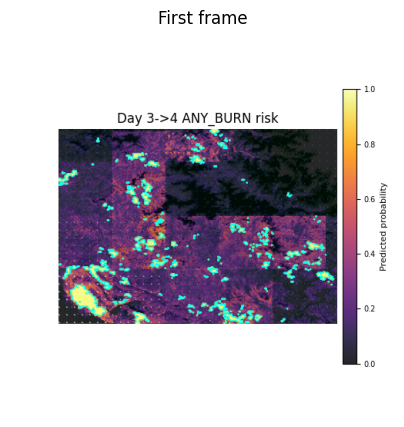

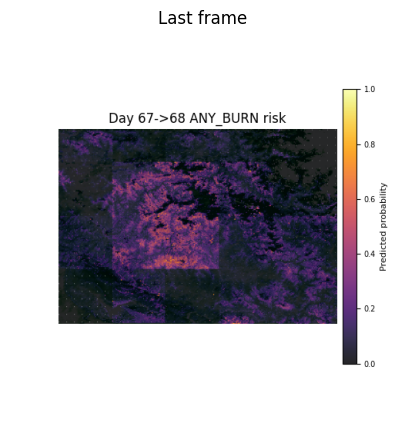

Saved last frame PNG -> last_prediction_frame.png
 last_prediction_frame.png


In [38]:
PRED_TARGET = 'ANY_BURN'   
INCLUDE_ACTUAL_NEXT = True 
INCLUDE_WIND = True        
INCLUDE_THRESHOLD_MASK = True  
THRESH_OVERRIDE = None     
WIND_STRIDE = 8           
ALPHA_RISK = 0.85          
ALPHA_ACTUAL = 0.75        
ALPHA_PRED_MASK = 0.35     
FIGSIZE = (5,5)
CMAP_RISK = 'inferno'
CMAP_ACTUAL = 'hot'
CMAP_BASE = 'Greens'
GIF_PATH = 'predicted_risk_sequence.gif'
FPS = 4
LIMIT_FRAMES = None        
SHOW_PROGRESS = True
SAVE_LAST_FRAME_PNG = True
LAST_FRAME_PNG = 'last_prediction_frame.png'

import numpy as np, os
import matplotlib.pyplot as plt
try:
    import imageio.v2 as imageio
except Exception as e:
    raise SystemExit('imageio required: pip install imageio')

def fig_to_rgb_array(fig):
    fig.canvas.draw() 
    
    if hasattr(fig.canvas, 'buffer_rgba'):
        buf = np.asarray(fig.canvas.buffer_rgba())  
        if buf.shape[2] == 4:
            return buf[:, :, :3].copy()
        return buf.copy()
    
    if hasattr(fig.canvas, 'tostring_rgb') and hasattr(fig.canvas, 'get_width_height'):
        w, h = fig.canvas.get_width_height()
        buf = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        return buf.reshape(h, w, 3).copy()
    raise RuntimeError('No supported method to extract RGB buffer from figure canvas.')


if PRED_TARGET.upper() == 'ANY_BURN':
    if 'MODEL_ANY' not in globals() or MODEL_ANY is None:
        raise SystemExit('ANY_BURN model not trained (run Cell 5).')
    model = MODEL_ANY
    thr_default = THR_ANY if 'THR_ANY' in globals() and THR_ANY is not None else 0.5
elif PRED_TARGET.upper() == 'IGNITION':
    if 'MODEL_IGN' not in globals() or MODEL_IGN is None:
        raise SystemExit('IGNITION model not available (insufficient positives or not trained).')
    model = MODEL_IGN
    thr_default = THR_IGN if 'THR_IGN' in globals() and THR_IGN is not None else 0.5
else:
    raise ValueError('PRED_TARGET must be ANY_BURN or IGNITION')

thr_use = THRESH_OVERRIDE if (THRESH_OVERRIDE is not None) else thr_default
print(f'Using decision threshold: {thr_use:.4f}')

if T < LAG_DAYS + 1:
    raise SystemExit('Not enough days to form required lag windows for sequence.')


start_t = LAG_DAYS - 1
end_t = T - 2
usable_frames = end_t - start_t + 1
if usable_frames <= 0:
    raise SystemExit('No usable transitions (check data length).')
if LIMIT_FRAMES is not None:
    end_t = min(end_t, start_t + LIMIT_FRAMES - 1)

frames = []
for t in range(start_t, end_t + 1):
    
    dyn_lags = []
    for lag in range(LAG_DAYS):
        tt = t - lag
        dyn_lags.append(stack[tt, DYN_BASE_IDXS])  
    dyn_lags = dyn_lags[::-1]
    dyn_lags_arr = np.stack(dyn_lags, axis=0)  
    burn_now = (stack[t, B_BURN] > 0).astype('float32')
    static_feats = stack[t, STATIC_IDXS]
    diff_feats_arr = []
    if LAG_DAYS > 1 and 'INCLUDE_DIFFS' in globals() and INCLUDE_DIFFS:
        dfs = []
        for k in range(1, LAG_DAYS):
            dfs.append(dyn_lags_arr[k] - dyn_lags_arr[k-1])
        diff_feats_arr = np.stack(dfs, axis=0).reshape(-1, H, W) if dfs else []
    dyn_flat = dyn_lags_arr.reshape(LAG_DAYS*5, H, W)
    parts = [dyn_flat]
    if len(diff_feats_arr): parts.append(diff_feats_arr)
    parts.append(burn_now[None, ...])
    parts.append(static_feats)
    feats_full = np.concatenate(parts, axis=0)
    X_t = feats_full.reshape(feats_full.shape[0], -1).T
    
    prob = model.predict_proba(X_t)[:,1]
    risk = prob.reshape(H, W)
    
    base = stack[t, B_NDVI]
    if INCLUDE_ACTUAL_NEXT:
        actual_next = (stack[t+1, B_BURN] > 0).astype(float)
    
    pred_mask = (risk >= thr_use).astype(float) if INCLUDE_THRESHOLD_MASK else None

    fig, ax = plt.subplots(figsize=FIGSIZE)
   
    vmin_base = np.nanpercentile(base, 5)
    vmax_base = np.nanpercentile(base, 95)
    ax.imshow(base, cmap=CMAP_BASE, vmin=vmin_base, vmax=vmax_base)
    
    im = ax.imshow(risk, cmap=CMAP_RISK, alpha=ALPHA_RISK, vmin=0, vmax=1)
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
    cbar.ax.tick_params(labelsize=7)
    cbar.set_label('Predicted probability', fontsize=8)

   
    if pred_mask is not None:
        try:
            ax.contour(pred_mask, levels=[0.5], colors='yellow', linewidths=1.0)
            ax.imshow(np.ma.masked_where(pred_mask < 0.5, pred_mask), cmap='autumn', alpha=ALPHA_PRED_MASK, vmin=0, vmax=1)
        except Exception:
            pass
    
    if INCLUDE_ACTUAL_NEXT:
        try:
            ax.contour(actual_next, levels=[0.5], colors='cyan', linewidths=1.0)
            ax.imshow(np.ma.masked_where(actual_next < 0.5, actual_next), cmap=CMAP_ACTUAL, alpha=ALPHA_ACTUAL*0.25, vmin=0, vmax=1)
        except Exception:
            pass
    
    if INCLUDE_WIND:
        try:
            u = stack[t, B_U]
            v = stack[t, B_V]
            u_ds = u[::WIND_STRIDE, ::WIND_STRIDE]
            v_ds = v[::WIND_STRIDE, ::WIND_STRIDE]
            y_coords, x_coords = np.mgrid[0:u_ds.shape[0], 0:u_ds.shape[1]]
            ax.quiver(x_coords*WIND_STRIDE, y_coords*WIND_STRIDE, u_ds, v_ds, color='white', scale=300, width=0.002, alpha=0.8)
        except Exception as e:
            if SHOW_PROGRESS:
                print('Wind quiver skipped:', e)
    ax.set_title(f'Day {t+1}->{t+2} {PRED_TARGET} risk')
    ax.axis('off')

    frame = fig_to_rgb_array(fig)
    frames.append(frame)
    if SHOW_PROGRESS and ( (t-start_t+1) % 5 == 0 or t == end_t):
        print(f'Generated frame {t-start_t+1}/{end_t-start_t+1}')
    plt.close(fig)


imageio.mimsave(GIF_PATH, frames, fps=FPS)
print(f'GIF saved: {GIF_PATH}  | Frames: {len(frames)}')


plt.figure(figsize=FIGSIZE); plt.imshow(frames[0]); plt.title('First frame'); plt.axis('off'); plt.show()
plt.figure(figsize=FIGSIZE); plt.imshow(frames[-1]); plt.title('Last frame'); plt.axis('off'); plt.show()

if SAVE_LAST_FRAME_PNG:
    from imageio import imwrite
    imwrite(LAST_FRAME_PNG, frames[-1])
    print('Saved last frame PNG ->', LAST_FRAME_PNG)



Multi-horizon using threshold 0.9906 for target ANY_BURN
Reference frames: 63 (days 2..64)
Frame 5/63 built (ref day 7)
Frame 5/63 built (ref day 7)
Frame 10/63 built (ref day 12)
Frame 10/63 built (ref day 12)
Frame 15/63 built (ref day 17)
Frame 15/63 built (ref day 17)
Frame 20/63 built (ref day 22)
Frame 20/63 built (ref day 22)
Frame 25/63 built (ref day 27)
Frame 25/63 built (ref day 27)
Frame 30/63 built (ref day 32)
Frame 30/63 built (ref day 32)
Frame 35/63 built (ref day 37)
Frame 35/63 built (ref day 37)
Frame 40/63 built (ref day 42)
Frame 40/63 built (ref day 42)
Frame 45/63 built (ref day 47)
Frame 45/63 built (ref day 47)
Frame 50/63 built (ref day 52)
Frame 50/63 built (ref day 52)
Frame 55/63 built (ref day 57)
Frame 55/63 built (ref day 57)
Frame 60/63 built (ref day 62)
Frame 60/63 built (ref day 62)
Frame 63/63 built (ref day 65)
Frame 63/63 built (ref day 65)
Multi-horizon GIF written -> multi_horizon_risk.gif | Frames: 63
MP4 export skipped (encoder missing?): Cou

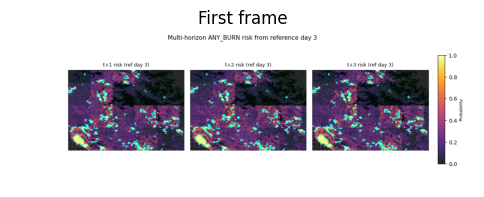

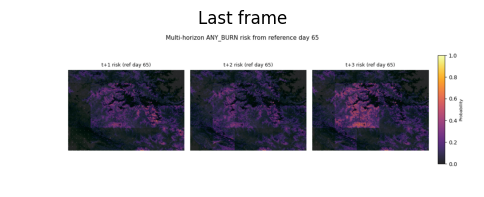

Saved sample PNG -> multi_horizon_sample.png
Cell 6b complete. Proceed to Cell 7 for original single-horizon / actual GIF if desired.


In [ ]:
HORIZONS = [1,2,3]          
TARGET = 'ANY_BURN'        
INCLUDE_ACTUAL = True        
INCLUDE_THRESHOLD = True    
THRESH_OVERRIDE = None       
ALPHA_RISK = 0.85
ALPHA_ACTUAL = 0.55
ALPHA_MASK = 0.30
FIGSIZE = (12,4)            
CMAP_RISK = 'inferno'
CMAP_BASE = 'Greens'
CMAP_ACTUAL = 'hot'
FPS = 3
OUTPUT_GIF = 'multi_horizon_risk.gif'
OUTPUT_MP4 = 'multi_horizon_risk.mp4'  
LIMIT_FRAMES = None          
SHOW_PROGRESS = True
SAVE_SAMPLE_PNG = True
SAMPLE_PNG = 'multi_horizon_sample.png'
WIND_VECTORS = True
WIND_STRIDE = 10

import numpy as np, os, matplotlib.pyplot as plt
try:
    import imageio.v2 as imageio
except Exception as e:
    raise SystemExit('imageio required: pip install imageio')


if 'fig_to_rgb_array' not in globals():
    def fig_to_rgb_array(fig):
        fig.canvas.draw()
        if hasattr(fig.canvas, 'buffer_rgba'):
            buf = np.asarray(fig.canvas.buffer_rgba())
            return buf[..., :3].copy() if buf.shape[2] == 4 else buf.copy()
        if hasattr(fig.canvas, 'tostring_rgb') and hasattr(fig.canvas, 'get_width_height'):
            w,h = fig.canvas.get_width_height(); buf = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
            return buf.reshape(h,w,3).copy()
        raise RuntimeError('No supported canvas buffer method.')

if TARGET.upper() == 'ANY_BURN':
    if 'MODEL_ANY' not in globals() or MODEL_ANY is None:
        raise SystemExit('ANY_BURN model not trained (run Cell 5).')
    model = MODEL_ANY
    thr_default = THR_ANY if 'THR_ANY' in globals() and THR_ANY is not None else 0.5
elif TARGET.upper() == 'IGNITION':
    if 'MODEL_IGN' not in globals() or MODEL_IGN is None:
        raise SystemExit('IGNITION model not available.')
    model = MODEL_IGN
    thr_default = THR_IGN if 'THR_IGN' in globals() and THR_IGN is not None else 0.5
else:
    raise ValueError('TARGET must be ANY_BURN or IGNITION')

thr_use = THRESH_OVERRIDE if THRESH_OVERRIDE is not None else thr_default
print(f'Multi-horizon using threshold {thr_use:.4f} for target {TARGET}')

max_h = max(HORIZONS)

start_ref = LAG_DAYS - 1
end_ref = T - 1 - max_h  
if end_ref < start_ref:
    raise SystemExit('Not enough days for requested horizons. Reduce HORIZONS or collect more data.')

ref_days = list(range(start_ref, end_ref + 1))
if LIMIT_FRAMES is not None:
    ref_days = ref_days[:LIMIT_FRAMES]
print(f'Reference frames: {len(ref_days)} (days {ref_days[0]}..{ref_days[-1]})')

frames = []
for idx, t in enumerate(ref_days):
    fig, axes = plt.subplots(1, len(HORIZONS), figsize=FIGSIZE)
    if len(HORIZONS) == 1:
        axes = [axes]
    for ax, h in zip(axes, HORIZONS):
        
        in_day = t + h - 1
        pred_day = t + h
        
        dyn_lags = []
        for lag in range(LAG_DAYS):
            tt = in_day - lag
            dyn_lags.append(stack[tt, DYN_BASE_IDXS])
        dyn_lags = dyn_lags[::-1]
        dyn_lags_arr = np.stack(dyn_lags, axis=0)  
        burn_now = (stack[in_day, B_BURN] > 0).astype('float32')
        static_feats = stack[in_day, STATIC_IDXS]
        diff_feats_arr = []
        if LAG_DAYS > 1 and 'INCLUDE_DIFFS' in globals() and INCLUDE_DIFFS:
            dfs = []
            for k in range(1, LAG_DAYS):
                dfs.append(dyn_lags_arr[k] - dyn_lags_arr[k-1])
            diff_feats_arr = np.stack(dfs, axis=0).reshape(-1, H, W) if dfs else []
        dyn_flat = dyn_lags_arr.reshape(LAG_DAYS*5, H, W)
        parts = [dyn_flat]
        if len(diff_feats_arr): parts.append(diff_feats_arr)
        parts.append(burn_now[None, ...])
        parts.append(static_feats)
        feats_full = np.concatenate(parts, axis=0)
        X_in = feats_full.reshape(feats_full.shape[0], -1).T
        prob = model.predict_proba(X_in)[:,1]
        risk = prob.reshape(H, W)
        base = stack[in_day, B_NDVI]
        vmin_base = np.nanpercentile(base,5); vmax_base = np.nanpercentile(base,95)
        ax.imshow(base, cmap=CMAP_BASE, vmin=vmin_base, vmax=vmax_base)
        im = ax.imshow(risk, cmap=CMAP_RISK, alpha=ALPHA_RISK, vmin=0, vmax=1)
        if INCLUDE_THRESHOLD:
            mask = (risk >= thr_use).astype(float)
            try:
                ax.contour(mask, levels=[0.5], colors='yellow', linewidths=0.9)
                ax.imshow(np.ma.masked_where(mask < 0.5, mask), cmap='autumn', alpha=ALPHA_MASK, vmin=0, vmax=1)
            except Exception:
                pass
        if INCLUDE_ACTUAL and pred_day < T:
            actual = (stack[pred_day, B_BURN] > 0).astype(float)
            try:
                ax.contour(actual, levels=[0.5], colors='cyan', linewidths=0.9)
                ax.imshow(np.ma.masked_where(actual < 0.5, actual), cmap=CMAP_ACTUAL, alpha=ALPHA_ACTUAL*0.25, vmin=0, vmax=1)
            except Exception:
                pass
        if WIND_VECTORS:
            try:
                u = stack[in_day, B_U]; vfield = stack[in_day, B_V]
                u_ds = u[::WIND_STRIDE, ::WIND_STRIDE]; v_ds = vfield[::WIND_STRIDE, ::WIND_STRIDE]
                y_coords, x_coords = np.mgrid[0:u_ds.shape[0], 0:u_ds.shape[1]]
                ax.quiver(x_coords*WIND_STRIDE, y_coords*WIND_STRIDE, u_ds, v_ds, color='white', scale=300, width=0.002, alpha=0.75)
            except Exception:
                pass
        ax.set_title(f't+{h} risk (ref day {t+1})', fontsize=9)
        ax.axis('off')

    cax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
    fig.colorbar(im, cax=cax).set_label('Probability', fontsize=8)
    fig.suptitle(f'Multi-horizon {TARGET} risk from reference day {t+1}', fontsize=11)
    plt.subplots_adjust(right=0.90, wspace=0.05)
    frame = fig_to_rgb_array(fig)
    frames.append(frame)
    if SHOW_PROGRESS and ((idx+1) % 5 == 0 or idx == len(ref_days)-1):
        print(f'Frame {idx+1}/{len(ref_days)} built (ref day {t+1})')
    plt.close(fig)


imageio.mimsave(OUTPUT_GIF, frames, fps=FPS)
print('Multi-horizon GIF written ->', OUTPUT_GIF, '| Frames:', len(frames))


mp4_ok = False
try:
    imageio.mimsave(OUTPUT_MP4, frames, fps=FPS)
    mp4_ok = True
    print('MP4 written ->', OUTPUT_MP4)
except Exception as e:
    print('MP4 export skipped (encoder missing?):', e)


plt.figure(figsize=(6,4)); plt.imshow(frames[0]); plt.title('First frame'); plt.axis('off'); plt.show()
plt.figure(figsize=(6,4)); plt.imshow(frames[-1]); plt.title('Last frame'); plt.axis('off'); plt.show()

if SAVE_SAMPLE_PNG:
    from imageio import imwrite
    imwrite(SAMPLE_PNG, frames[-1])
    print('Saved sample PNG ->', SAMPLE_PNG)
